# IS 675 Lab 6 - Using a Neural Network to Fit the Data (2)

##1. Training, testing, and overfitting

In [ ]:
# Import required libraries
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim
torch.set_printoptions(edgeitems=2, linewidth=75)

Consider the thermometer example

In [ ]:
# Load the data in tensors: observed values in unkown units (t_u) versus ground truth values in Celsius (t_c)
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)
t_u.shape

torch.Size([11])

We want to estimate a linear model like this: t_c = w * t_u + b

In [ ]:
# Choose a linear model as a first try
# Notice how broadcasting works
def model(t_u, w, b):
    return w * t_u + b

In [ ]:
# Define the loss function
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [ ]:
# Split the dataset randomly based on its indices (20% for test)
n_samples = t_u.shape[0]
n_test = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_test]
test_indices = shuffled_indices[-n_test:]

train_indices, test_indices  # Since these are random, don’t be surprised if your values end up different from here on out

(tensor([ 0, 10,  2,  6,  4,  3,  5,  7,  9]), tensor([1, 8]))

In [ ]:
# Build training and testing sets
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

test_t_u = t_u[test_indices]
test_t_c = t_c[test_indices]

train_t_un = 0.1 * train_t_u
test_t_un = 0.1 * test_t_u

Our training loop doesn’t really change. We just want to additionally evaluate the test loss at every epoch, to have a chance to recognize whether we’re overfitting:

In [ ]:
# Build the training loop
def training_loop(n_epochs, optimizer, params, train_t_u, test_t_u,
                  train_t_c, test_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)

        test_t_p = model(test_t_u, *params)
        test_loss = loss_fn(test_t_p, test_t_c)

        optimizer.zero_grad()
        train_loss.backward() # there is no test_loss.backward() here, since we don’t want to train the model on the test data.
        optimizer.step()

        if epoch <= 3 or epoch % 5000 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Test loss {test_loss.item():.4f}")

    return params

In [ ]:
# Train the model
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs = 30000,
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un, # Since we’re using SGD again, we’re back to using normalized inputs
    test_t_u = test_t_un,
    train_t_c = train_t_c,
    test_t_c = test_t_c)

Epoch 1, Training loss 90.2149, Test loss 36.0368
Epoch 2, Training loss 41.4711, Test loss 11.0918
Epoch 3, Training loss 34.1537, Test loss 12.0619
Epoch 5000, Training loss 2.5641, Test loss 4.7285
Epoch 10000, Training loss 2.5641, Test loss 4.7284
Epoch 15000, Training loss 2.5641, Test loss 4.7284
Epoch 20000, Training loss 2.5641, Test loss 4.7284
Epoch 25000, Training loss 2.5641, Test loss 4.7284
Epoch 30000, Training loss 2.5641, Test loss 4.7284


tensor([  5.3166, -16.8875], requires_grad=True)

The model is evaluated twice—once on train_t_u and once on test_t_u—and then backward is called. Won’t this confuse autograd? Won’t backward be influenced by the values generated during the pass on the test set?

In [ ]:
# Switch off auto-grad for the test data
def training_loop(n_epochs, optimizer, params, train_t_u, test_t_u,
                  train_t_c, test_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)

        with torch.no_grad(): # This is called a Context manager
            test_t_p = model(test_t_u, *params)
            test_loss = loss_fn(test_t_p, test_t_c)
            assert test_loss.requires_grad == False # our output requires_grad args are forced to False inside this block

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

##2. All we need is activation
As we have seen, the simplest unit in (deep) neural networks is a linear operation followed by an activation function. We already had our linear operation in our latest model—the linear operation was the entire model. The activation function plays two important roles:

1- Capturing the non-linearity and smoothing the model

2- At the last layer of the network, it has the role of concentrating the outputs of the preceding linear operation into a given range.

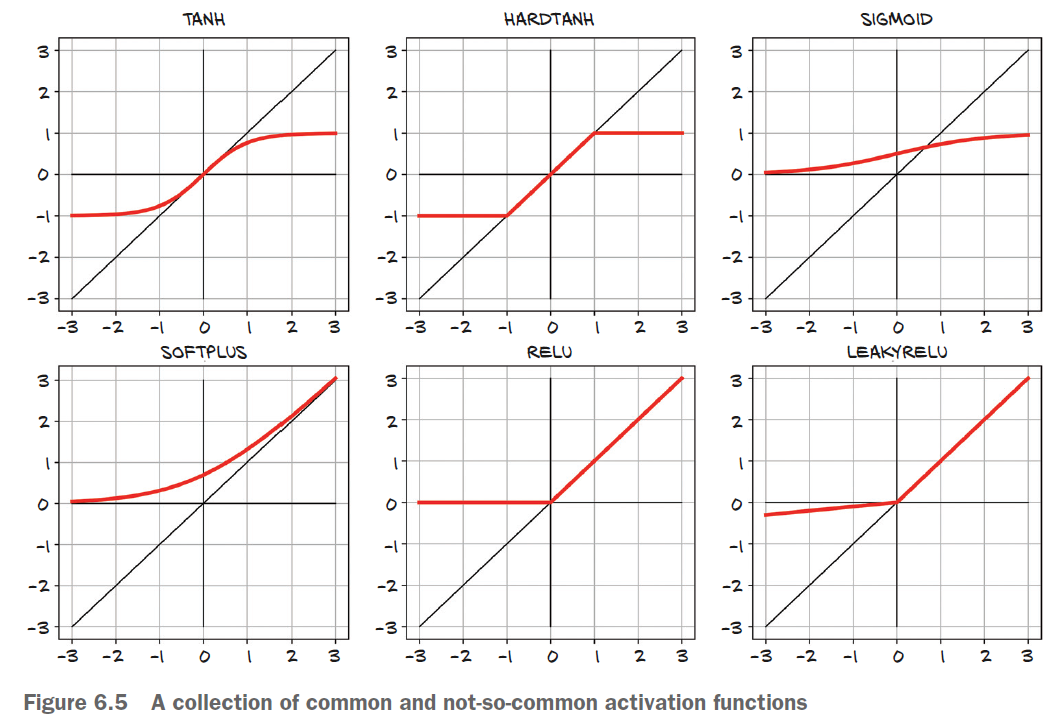

##3. The PyTorch nn module
Our first step to build a neural network will be to replace our linear model with a neural network unit. PyTorch has a whole submodule dedicated to neural networks, called **torch.nn**. It contains the building blocks needed to create all sorts of neural network architectures. Those building blocks are called modules in PyTorch parlance (such building blocks are often referred to as layers in other frameworks). A PyTorch module is a Python class deriving from the **nn.Module** base class. A module can have one or more Parameter instances as attributes, which are tensors whose values are optimized during the training process (think w and b in our linear model). A module can also have one or more submodules (subclasses of nn.Module) as attributes, and it will be able to track their parameters as well.

Unsurprisingly, we can find a subclass of nn.Module called **nn.Linear**, which applies an affine transformation to its input (via the parameter attributes weight and bias) and is equivalent to what we implemented earlier in our thermometer experiments.

###3.1. Using \__call__ rather than forward

All PyTorch-provided subclasses of nn.Module have their \__call__ method defined. This allows us to instantiate an nn.Linear and call it as if it was a function.

In [ ]:
# Import nn
import torch.nn as nn

In [ ]:
# Instantiate an nn.Linear subclass
linear_model = nn.Linear(1, 2) # This means exactly what we did before
test_t_un = test_t_un.reshape(-1, 1)
linear_model(test_t_un)

tensor([[-3.0023,  1.5339],
        [-2.6968,  1.3367]], grad_fn=<AddmmBackward0>)

Oops.. Why we got error?

**It indicates that there is a mismatch in the dimensions of the input tensor(test_t_un) and weights of the linear layer (linear_model). We can change the features from either input tensor or the linear model, to keep the same number of features(columns). Reshaped the features in the tensor and the linear model to avoid errors.**

In [ ]:
#The nn.Linear only takes data in batches (remember lecture 3 when we wanted to use pretrained models)
t_c = torch.tensor(t_c).unsqueeze(1) # Adds the extra dimension at axis 1
t_u = torch.tensor(t_u).unsqueeze(1) # Adds the extra dimension at axis 1
t_u.shape

<ipython-input-73-95fa121fd41b>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_c = torch.tensor(t_c).unsqueeze(1) # Adds the extra dimension at axis 1
<ipython-input-73-95fa121fd41b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_u = torch.tensor(t_u).unsqueeze(1) # Adds the extra dimension at axis 1


torch.Size([11, 1])

In [ ]:
# Update tensors with an extra dimension, I also changes the names :)
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_test = t_u[test_indices]
t_c_test = t_c[test_indices]

t_un_train = 0.1 * t_u_train
t_un_test = 0.1 * t_u_test

In [ ]:
# Instantiate an nn.Linear subclass
linear_model = nn.Linear(1, 1) # This means exactly what we did before
linear_model(t_un_test)

tensor([[0.2717],
        [0.2810]], grad_fn=<AddmmBackward0>)

In [ ]:
# Examine the linear model weight
linear_model.weight

Parameter containing:
tensor([[-0.0123]], requires_grad=True)

In [ ]:
# Examine the linear model bias
linear_model.bias

Parameter containing:
tensor([0.3407], requires_grad=True)

In [ ]:
# Examine the linear model with a tensor of ones
x = torch.ones(10, 1)
linear_model(x)

tensor([[0.3283],
        [0.3283],
        [0.3283],
        [0.3283],
        [0.3283],
        [0.3283],
        [0.3283],
        [0.3283],
        [0.3283],
        [0.3283]], grad_fn=<AddmmBackward0>)

In [ ]:
# The model has forward method, but do not use it
y = linear_model.forward(x)
y

tensor([[0.3283],
        [0.3283],
        [0.3283],
        [0.3283],
        [0.3283],
        [0.3283],
        [0.3283],
        [0.3283],
        [0.3283],
        [0.3283]], grad_fn=<AddmmBackward0>)

In [ ]:
# Do this for a forward pass
y = linear_model(x)
y

tensor([[0.3283],
        [0.3283],
        [0.3283],
        [0.3283],
        [0.3283],
        [0.3283],
        [0.3283],
        [0.3283],
        [0.3283],
        [0.3283]], grad_fn=<AddmmBackward0>)

Now let’s update our training code. First, we replace our handmade model with nn.Linear(1,1), and then we need to pass the linear model parameters to the optimizer:

In [ ]:
linear_model = nn.Linear(1, 1) # This is exactly our model
optimizer = optim.SGD(
    linear_model.parameters(), # This method call replaces [params].
    lr=1e-2)

Earlier, it was our responsibility to create parameters and pass them as the first argument to optim.SGD. Now we can use the parameters method to ask any nn.Module for a list of parameters owned by it or any of its submodules.

In [ ]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.3967]], requires_grad=True),
 Parameter containing:
 tensor([-0.6534], requires_grad=True)]

This call recurses into submodules defined in the module’s ***init*** constructor and
returns a flat list of all parameters encountered, so that we can conveniently pass it to the optimizer constructor as we did previously.

We can already figure out what happens in the training loop. The optimizer is provided with a list of tensors that were defined with requires_grad = True—all Parameters are defined this way by definition, since they need to be optimized by gradient descent. When **training_loss.backward()** is called, grad is accumulated. At this point, the SGD optimizer has everything it needs. When **optimizer.step()** is called, it will iterate through each Parameter and change it by an amount proportional to what is stored in its grad attribute. Pretty clean design.

In [ ]:
# Build the training loop
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_test,
                  t_c_train, t_c_test):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # The model is now passed in, instead of the individual params
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_test = model(t_u_test) # The model is now passed in, instead of the individual params
        loss_test = loss_fn(t_p_test, t_c_test)

        optimizer.zero_grad()
        loss_train.backward() # The loss function is also passed in. We’ll use it in a moment.
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Test loss {loss_test.item():.4f}")

It hasn’t changed practically at all, except that now we don’t pass params explicitly to model since the model itself holds its Parameters internally.

There’s one last bit that we can leverage from torch.nn: **the loss**. Indeed, nn comes with several common loss functions, among them **nn.MSELoss** (MSE stands for Mean Square Error), which is exactly what we defined earlier as our loss_fn. **Loss functions in nn are still subclasses of nn.Module**, so we will create an instance and call it as a function. In our case, we get rid of the handwritten loss_fn and replace it:

In [ ]:
# Train the model
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)
training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # We are no longer using our handwritten loss function from earlier.
    t_u_train = t_un_train,
    t_u_test = t_un_test,
    t_c_train = t_c_train,
    t_c_test = t_c_test)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 135.0322, Test loss 63.6342
Epoch 1000, Training loss 3.1489, Test loss 5.7929
Epoch 2000, Training loss 2.5743, Test loss 4.8600
Epoch 3000, Training loss 2.5643, Test loss 4.7454

Parameter containing:
tensor([[5.3096]], requires_grad=True)
Parameter containing:
tensor([-16.8470], requires_grad=True)


##4. Finally a neural network
It’s been a long journey so far! Now we only need to replace the linear model with our design of a neural network including hidden layers and activation functions. Luckily, **nn** provides a simple way to concatenate modules through the **nn.Sequential** container:

In [ ]:
# Build a neural network for the thermometer problem with one hidden layer (containing 13 neurons) and tanh as activation
seq_model = nn.Sequential(
            nn.Linear(1, 13), # We chose 13 arbitrarily. We wanted a number that was a different size from the other tensor shapes we have floating around.
            nn.Tanh(),
            nn.Linear(13, 1)) # This 13 must match the first size, however
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [ ]:
# Running our first neural network
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # We’ve dropped the learning rate a bit to help with stability.

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_test = t_un_test,
    t_c_train = t_c_train,
    t_c_test = t_c_test)

print('output', seq_model(t_un_test))
print('answer', t_c_test)

Epoch 1, Training loss 220.3922, Test loss 131.6253
Epoch 1000, Training loss 4.9778, Test loss 4.8584
Epoch 2000, Training loss 5.0311, Test loss 7.6232
Epoch 3000, Training loss 3.2800, Test loss 4.5468
Epoch 4000, Training loss 2.1044, Test loss 3.1659
Epoch 5000, Training loss 1.8487, Test loss 3.1251
output tensor([[11.3739],
        [ 7.1624]], grad_fn=<AddmmBackward0>)
answer tensor([[14.],
        [ 6.]])


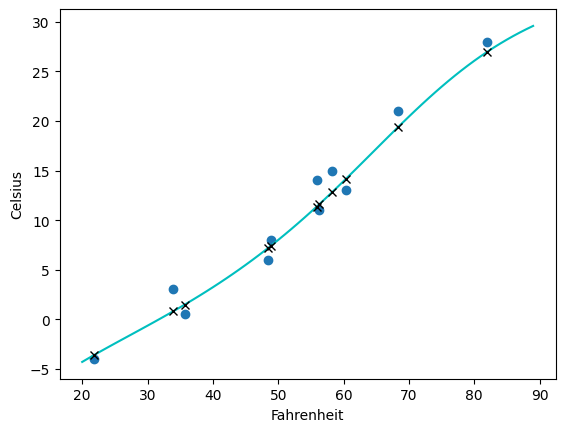

In [ ]:
# Plot and compare to the linear model
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=100)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
# The .squeeze() method removes all the dimensions of size 1
plt.plot(t_u.numpy().squeeze(), t_c.numpy().squeeze(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy().squeeze(), seq_model(0.1 * t_u).detach().numpy().squeeze(), 'kx')

Notice how the neural network tends to overfit!

##5. Car kick classification using neural networks
This data set contains information of cars purchased at the Auction.
<br>
We will use this file to predict the quality of buying decisions and visualize decision processes.
<br>
<br>
VARIABLE DESCRIPTIONS:<br>
Auction: Auction provider at which the  vehicle was purchased<br>
Color: Vehicle Color<br>
IsBadBuy: Identifies if the kicked vehicle was an avoidable purchase<br>
MMRCurrentAuctionAveragePrice: Acquisition price for this vehicle in average condition as of current day<br>
Size: The size category of the vehicle (Compact, SUV, etc.)<br>
TopThreeAmericanName:Identifies if the manufacturer is one of the top three American manufacturers<br>
VehBCost: Acquisition cost paid for the vehicle at time of purchase<br>
VehicleAge: The Years elapsed since the manufacturer's year<br>
VehOdo: The vehicles odometer reading<br>
WarrantyCost: Warranty price (term=36month  and millage=36K)<br>
WheelType: The vehicle wheel type description (Alloy, Covers)<br>
<br>
Target variable: **IsBadBuy**

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing

In [ ]:
# Read data
car_kick = pd.read_csv("/content/drive/MyDrive/IS675_data/car_kick.csv")

In [ ]:
# Select the desired columns only
desired_columns = ['Auction', 'Color', 'IsBadBuy', 'MMRCurrentAuctionAveragePrice', 'Size','TopThreeAmericanName',
'VehBCost', 'VehicleAge', 'VehOdo', 'WarrantyCost', 'WheelType']
car_kick_desired = car_kick [desired_columns]

In [ ]:
# Replacing 1 with Yes and 0 with No in the target column IsBadBuy
carAuction = car_kick_desired.copy() #why?
carAuction.loc[:, 'IsBadBuy'] = carAuction['IsBadBuy'].replace({0: 'No', 1: 'Yes'})

<ipython-input-92-d8ec7e190e37>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['No' 'No' 'No' ... 'Yes' 'Yes' 'Yes']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  carAuction.loc[:, 'IsBadBuy'] = carAuction['IsBadBuy'].replace({0: 'No', 1: 'Yes'})


In [ ]:
# Examine variable type
carAuction.dtypes

,0
Auction,object
Color,object
IsBadBuy,object
MMRCurrentAuctionAveragePrice,int64
Size,object
TopThreeAmericanName,object
VehBCost,int64
VehicleAge,int64
VehOdo,int64
WarrantyCost,int64


In [ ]:
# Change categorical variables to "category"
carAuction['Auction'] = carAuction['Auction'].astype('category')
carAuction['Color'] = carAuction['Color'].astype('category')
carAuction['IsBadBuy'] = carAuction['IsBadBuy'].astype('category')
carAuction['Size'] = carAuction['Size'].astype('category')
carAuction['TopThreeAmericanName'] = carAuction['TopThreeAmericanName'].astype('category')
carAuction['WheelType'] = carAuction['WheelType'].astype('category')

In [ ]:
# Create dummy variables
carAuction = pd.get_dummies(carAuction, columns=['Auction','Color','Size','TopThreeAmericanName','WheelType'], drop_first=True)

In [ ]:
# Take the target and examine the porportion of target variable for each class
target = carAuction['IsBadBuy']
print(target.value_counts(normalize=True))

IsBadBuy
No     0.904539
Yes    0.095461
Name: proportion, dtype: float64


In [ ]:
# Drop the target variable and put all the predictors in a new dataframe
predictors = carAuction.drop(['IsBadBuy'],axis=1)

In [ ]:
# Apply minmax normalization on predictors
min_max_scaler = preprocessing.MinMaxScaler()
predictors_normalized = pd.DataFrame(min_max_scaler.fit_transform(predictors))
predictors_normalized.columns = predictors.columns

In [ ]:
# Partition the data
predictors_train, predictors_test, target_train, target_test = train_test_split(predictors_normalized, target, test_size=0.3, random_state=0)
print(predictors_train.shape, predictors_test.shape, target_train.shape, target_test.shape)

(47047, 38) (20164, 38) (47047,) (20164,)


In [ ]:
# Taking steps to balance the train data
# Combine predictors_train and target_train into a single DataFrame
combined_train_df = pd.concat([predictors_train, target_train], axis=1)

# Separate majority and minority classes
majority_df = combined_train_df[combined_train_df['IsBadBuy'] == 'No']
minority_df = combined_train_df[combined_train_df['IsBadBuy'] == 'Yes']

# Undersample the majority class randomly
undersampled_majority = majority_df.sample(n=len(minority_df), random_state=5)

# Combine the undersampled majority class and the minority class
undersampled_data = pd.concat([undersampled_majority, minority_df])

# Shuffle the combined DataFrame to ensure randomness
balanced_data = undersampled_data.sample(frac=1, random_state=5)

# Split the balanced_data into predictors_train and target_train
predictors_train = balanced_data.drop(columns=['IsBadBuy'])
target_train = balanced_data['IsBadBuy']

In [ ]:
# Examine the porportion of target variable for training data set
print(target_train.value_counts(normalize=True))

IsBadBuy
No     0.5
Yes    0.5
Name: proportion, dtype: float64


In [ ]:
# Examine the porportion of target variable for testing data set
print(target_test.value_counts(normalize=True))

IsBadBuy
No     0.900962
Yes    0.099038
Name: proportion, dtype: float64


In [ ]:
#Encode label to numeric
label_encoder = preprocessing.LabelEncoder ()
new_label = label_encoder.fit(target_train)
new_label = label_encoder.transform(target_train)

print(target_train[:5], new_label[:5])

25382     No
26852    Yes
14428     No
13012    Yes
46509    Yes
Name: IsBadBuy, dtype: category
Categories (2, object): ['No', 'Yes'] [0 1 0 1 1]


In [ ]:
# Create tensors from pandas datafrane
predictors_train_tensor = torch.tensor(predictors_train.values)
target_train_tensor = torch.tensor(label_encoder.transform(target_train.values) )
predictors_test_tensor = torch.tensor(predictors_test.values)
target_test_tensor = torch.tensor (label_encoder. transform(target_test.values) )

# Create tensor dataset (set target variable to long int type)
train_dataset = torch.utils.data.TensorDataset(predictors_train_tensor.float (), target_train_tensor.long ())
test_dataset = torch.utils.data.TensorDataset(predictors_test_tensor. float () , target_test_tensor.long())

# Define training and testing data loader, and set batch size to 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# Define the neural network model with one hidden layer as a class
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),  # Activation function
            nn.Linear(hidden_size, output_size),
            #nn.Softmax(dim=1)  # Softmax activation for classification
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Define model parameters
input_size = len(train_loader.dataset[0][0])  # Input size based on the dataset
hidden_size = 64  # Desired size of the hidden layer
output_size = 2  # Number of classes (Yes and No)

In [ ]:
# Initialize the model and optimizer
torch.manual_seed(0)
model = Classifier(input_size, hidden_size, output_size)
optimizer = optim.SGD(model.parameters(), lr=0.0001)  # Adjust learning rate as needed
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification

In [ ]:
# Training loop
def train(model, train_loader, optimizer, criterion, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

In [ ]:
# Train the model
num_epochs = 20  # The number of epochs as needed
train(model, train_loader, optimizer, criterion, num_epochs)

In [ ]:
# Test function to generate a confusion matrix
def test(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.numpy())
            all_preds.extend(predicted.numpy())

    return confusion_matrix(all_labels, all_preds)

In [ ]:
# Evaluate the model using the test function
confusion = test(model, test_loader)
print("Confusion Matrix:")
print(confusion)

Confusion Matrix:
[[11709  6458]
 [ 1145   852]]


Q1. Write a traing loop that takes the same arguments as before but traces the train loss in each epoch.

In [ ]:
# Q1

In [ ]:
def train(model, train_loader, optimizer, criterion, num_epochs):
    model.train()

    epoch_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        num_batches = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            num_batches += 1

        # Average loss for the current epoch
        epoch_loss = running_loss / num_batches
        epoch_losses.append(epoch_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    return epoch_losses

Q2. Train the model using your training loop.

In [ ]:
# Q2

In [ ]:
num_epochs = 30
train(model, train_loader, optimizer, criterion, num_epochs)

Epoch 1/30, Loss: 0.6905
Epoch 2/30, Loss: 0.6905
Epoch 3/30, Loss: 0.6904
Epoch 4/30, Loss: 0.6905
Epoch 5/30, Loss: 0.6904
Epoch 6/30, Loss: 0.6903
Epoch 7/30, Loss: 0.6904
Epoch 8/30, Loss: 0.6902
Epoch 9/30, Loss: 0.6903
Epoch 10/30, Loss: 0.6903
Epoch 11/30, Loss: 0.6902
Epoch 12/30, Loss: 0.6902
Epoch 13/30, Loss: 0.6902
Epoch 14/30, Loss: 0.6901
Epoch 15/30, Loss: 0.6900
Epoch 16/30, Loss: 0.6901
Epoch 17/30, Loss: 0.6900
Epoch 18/30, Loss: 0.6900
Epoch 19/30, Loss: 0.6901
Epoch 20/30, Loss: 0.6899
Epoch 21/30, Loss: 0.6901
Epoch 22/30, Loss: 0.6900
Epoch 23/30, Loss: 0.6899
Epoch 24/30, Loss: 0.6899
Epoch 25/30, Loss: 0.6898
Epoch 26/30, Loss: 0.6898
Epoch 27/30, Loss: 0.6897
Epoch 28/30, Loss: 0.6896
Epoch 29/30, Loss: 0.6898
Epoch 30/30, Loss: 0.6897


[0.690499524847209,
 0.6904875108663985,
 0.6904435642331624,
 0.6904994322241639,
 0.690431535243988,
 0.6902875364255562,
 0.6903988277311806,
 0.6902210416553689,
 0.6903216028385025,
 0.690294437271228,
 0.6902495549737121,
 0.6902461124838685,
 0.6901903898595906,
 0.6901244726970042,
 0.6900069640694763,
 0.6901042564309758,
 0.6900013166365864,
 0.6900429091007589,
 0.6901324773006302,
 0.6898915351723596,
 0.6901012448955783,
 0.6899980975569581,
 0.6898697563212552,
 0.6898648442981912,
 0.6898184032748929,
 0.6898296827034984,
 0.6897146015716114,
 0.6896425395560779,
 0.6898154796456262,
 0.6896670567903588]

Q3. Evaluate the model on the training data. Other than the cofusion matrix, calculate other metrics for classification like precision, recall, and f1_score for the IsBadBuy = 'Yes' class, as well as the overal accuracy.
**Note**: To build the confusion matrix you do not need to define a function, simply use the existing test function.

In [ ]:
# Q3 - Confusion matrix

In [ ]:
confusion = test(model, train_loader)
print("Confusion Matrix:")
print(confusion)

Confusion Matrix:
[[2754 1665]
 [2339 2080]]


In [ ]:
# Q3 - metrics

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

target_class = 1
precision = precision_score(all_labels, all_preds, pos_label=target_class, average='binary')
recall = recall_score(all_labels, all_preds, pos_label=target_class, average='binary')
f1 = f1_score(all_labels, all_preds, pos_label=target_class, average='binary')
accuracy = accuracy_score(all_labels, all_preds)

print("\nClassification Metrics for 'Yes' Class on training data:")
print(f"Precision: {precision:}")
print(f"Recall:    {recall:}")
print(f"F1 Score:  {f1:}")
print(f"Overall Accuracy: {accuracy:}")


Classification Metrics for 'Yes' Class on training data:
Precision: 0.5554072096128171
Recall:    0.4706947273138719
F1 Score:  0.5095541401273885
Overall Accuracy: 0.5469563249603983


Q4. Evaluate the model's performance on the test data.

In [ ]:
#Q4 Confusion matrix

confusion = test(model, test_loader)
print("Confusion Matrix:")
print(confusion)

Confusion Matrix:
[[11243  6924]
 [ 1041   956]]


In [ ]:
# Q4 - metrics
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

target_class = 1
precision = precision_score(all_labels, all_preds, pos_label=target_class, average='binary')
recall = recall_score(all_labels, all_preds, pos_label=target_class, average='binary')
f1 = f1_score(all_labels, all_preds, pos_label=target_class, average='binary')
accuracy = accuracy_score(all_labels, all_preds)

print("\nClassification Metrics for 'Yes' Class on test data:")
print(f"Precision: {precision:}")
print(f"Recall:    {recall:}")
print(f"F1 Score:  {f1:}")
print(f"Overall Accuracy: {accuracy:}")


Classification Metrics for 'Yes' Class on test data:
Precision: 0.12131979695431472
Recall:    0.4787180771156735
F1 Score:  0.19358104687658195
Overall Accuracy: 0.6049890894663758


Q5. Why we didn't need to have an activation function for the output layer? How we addressed this issue? You must refer to the cell where we could fix this.

**Answer: We are not using an activation function in the output layer of our model because the model uses Cross Entropy loss function which takes care of the activation internally.**

**We have initialised the Cross entropy loss function when we were initializing the model and optimizer.**


```
# Initialize the model and optimizer
torch.manual_seed(0)
model = Classifier(input_size, hidden_size, output_size)
optimizer = optim.SGD(model.parameters(), lr=0.0001)  # Adjust learning rate as needed
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification

```


**Please close all unnecessary logs and keep your run results only!**
You are not reading the lab's instructions given on Canvas, that is why you lose points sometimes.

In [ ]:
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/IS675_lab06.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/IS675_lab06.ipynb to html
[NbConvertApp] Writing 1054876 bytes to /content/drive/MyDrive/Colab Notebooks/IS675_lab06.html
